In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
import scipy as sp
import scib
import seaborn as sns
import anndata as ad
import os
import sys

/mnt/nas/user/yixuan/miniconda3/envs/py10_torch2/lib/python3.10/site-packages/cupy/_environment.py:540: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda11x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


In [2]:
class RootCellError(Exception):
    def __init__(self, message):
        self.message = message

In [3]:
plt.rcParams["font.size"] = 10
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15, 15)
plt.rcParams.update({'axes.titlesize': 'x-large'})
sns.set(font_scale=1.5, style='white')
sns.set_context('poster')
sns.set(font_scale=1.5)
#sns.set_context("poster", rc={"axes.titlesize":20}) 
sns.set_style(style='white')
plt.rcParams["font.family"] = "sans-serif"
sns.set_palette(palette=sc.pl.palettes.godsnot_102)

In [4]:
def trajectory_conservation(
    adata_pre, adata_post, label_key, pseudotime_key="dpt_pseudotime", batch_key=None
):
    """Trajectory conservation score

    Trajectory conservation is measured by  spearman’s rank correlation coefficient :math:`s`, between the pseudotime
    values before and after integration.
    The final score was scaled to a value between 0 and 1 using the equation

     .. math::

        trajectory \\, conservation = \\frac {s + 1} {2}

    :param adata_pre: unintegrated adata
    :param adata_post: integrated adata
    :param label_key: column in ``adata_pre.obs`` of the groups used to precompute the trajectory
    :param pseudotime_key: column in ``adata_pre.obs`` in which the pseudotime is saved in.
        Column can contain empty entries, the dataset will be subset to the cells with scores.
    :param batch_key: set to batch key if you want to compute the trajectory metric by batch. By default the batch
        information will be ignored (``batch_key=None``)

    This function requires pseudotime values in ``.obs`` of the unintegrated object (``adata_pre``) computed per batch
    and can be applied to all integration output types.
    The input trajectories should be curated manually as the quality of the metric depends on the quality of the metric
    depends on the quality of the annotation.
    The integrated object (``adata_post``) needs to have a kNN graph based on the integration output.
    See :ref:`preprocessing` for more information on preprocessing.

    **Examples**

    .. code-block:: python

        # feature output
        scib.pp.reduce_data(
            adata, n_top_genes=2000, batch_key="batch", pca=True, neighbors=True
        )
        scib.me.trajectory_conservation(adata_unintegrated, adata, label_key="cell_type")

        # embedding output
        sc.pp.neighbors(adata, use_rep="X_emb")
        scib.me.trajectory_conservation(adata_unintegrated, adata, label_key="celltype")

        # knn output
        scib.me.trajectory_conservation(adata_unintegrated, adata, label_key="celltype")

    """
    # subset to cells for which pseudotime has been computed
    cell_subset = adata_pre.obs.index[adata_pre.obs[pseudotime_key].notnull()]
    adata_pre_ti = adata_pre[cell_subset]
    adata_post_ti = adata_post[cell_subset]
    try:
        iroot, adata_post_ti2 = get_root(
            adata_pre_ti, adata_post_ti, label_key, pseudotime_key
        )
    except RootCellError:
        print("No root cell found, setting trajectory conservation metric to 0.")
        return 0  # failure to find root cell means no TI conservation
    #print(iroot)
    adata_post_ti2.uns["iroot"] = iroot

    sc.tl.dpt(adata_post_ti2)  # stored in 'dpt_pseudotime'
    adata_post_ti2.obs.loc[
        adata_post_ti2.obs["dpt_pseudotime"] > 1, "dpt_pseudotime"
    ] = 0
    adata_post_ti.obs["dpt_pseudotime"] = 0
    adata_post_ti.obs["dpt_pseudotime"] = adata_post_ti2.obs["dpt_pseudotime"]
    adata_post_ti.obs["dpt_pseudotime"].fillna(0, inplace=True)

    if batch_key is None:
        pseudotime_before = adata_pre_ti.obs[pseudotime_key]
        pseudotime_after = adata_post_ti.obs["dpt_pseudotime"]
        correlation = pseudotime_before.corr(pseudotime_after, "spearman")
        return (correlation + 1) / 2  # scaled
    else:
        check_batch(batch_key, adata_pre.obs)
        check_batch(batch_key, adata_post.obs)

        # check if batches match
        if not np.array_equal(
            adata_post_ti.obs[batch_key], adata_pre_ti.obs[batch_key]
        ):
            raise ValueError(
                "Batch columns do not match\n"
                f"adata_post_ti.obs['batch']:\n {adata_post_ti.obs[batch_key]}\n"
                f"adata_pre_ti.obs['batch']:\n {adata_pre_ti.obs[batch_key]}\n"
            )

        corr = pd.Series()
        for i in adata_pre_ti.obs[batch_key].unique():
            pseudotime_before = adata_pre_ti.obs[adata_pre_ti.obs[batch_key] == i][
                pseudotime_key
            ]
            pseudotime_after = adata_post_ti.obs[adata_post_ti.obs[batch_key] == i][
                "dpt_pseudotime"
            ]
            corr[i] = pseudotime_before.corr(pseudotime_after, "spearman")

        return adata_post_ti,(corr.mean() + 1) / 2  # scaled


def get_root(adata_pre, adata_post, ct_key, pseudotime_key="dpt_pseudotime", dpt_dim=3):
    """Determine root cell for integrated adata based on unintegrated adata

    :param adata_pre: unintegrated adata
    :param adata_post: integrated adata
    :param label_key: column in ``adata_pre.obs`` of the groups used to precompute the trajectory
    :param pseudotime_key: column in ``adata_pre.obs`` in which the pseudotime is saved in.
        Column can contain empty entries, the dataset will be subset to the cells with scores.
    :param dpt_dim: number of diffmap dimensions used to determine root
    """
    n_components, adata_post.obs["neighborhood"] = connected_components(
        csgraph=adata_post.obsp["connectivities"], directed=False, return_labels=True
    )

    #start_clust = adata_pre.obs.groupby([ct_key],observed=True).mean()[pseudotime_key].idxmin()
    start_clust = adata_pre.obs.groupby([ct_key],observed=True)[pseudotime_key].mean().idxmin()
    #print(adata_post.obs["neighborhood"].value_counts().idxmax())
    min_dpt = adata_pre.obs[adata_pre.obs[ct_key] == start_clust].index
    # print('min_dpt',min_dpt)
    which_max_neigh = (
        adata_post.obs["neighborhood"]
        == adata_post.obs["neighborhood"].value_counts().idxmax()
    )
    # print('which_max_neigh',which_max_neigh)
    # print('adata_post.obs[which_max_neigh].index',adata_post.obs[which_max_neigh].index)
    min_dpt = [
        value for value in min_dpt if value in adata_post.obs[which_max_neigh].index
    ]
    # print('min_dpt',min_dpt)
    adata_post_ti = adata_post[which_max_neigh]

    min_dpt = [adata_post_ti.obs_names.get_loc(i) for i in min_dpt]
    
    # compute Diffmap for adata_post
    sc.tl.diffmap(adata_post_ti)
    # print('adata_post_ti.obs',adata_post_ti.obs)
    # print('min_dpt',min_dpt)
    # determine most extreme cell in adata_post Diffmap
    min_dpt_cell = np.zeros(len(min_dpt))
    for dim in np.arange(dpt_dim):

        diffmap_mean = adata_post_ti.obsm["X_diffmap"][:, dim].mean()
        diffmap_min_dpt = adata_post_ti.obsm["X_diffmap"][min_dpt, dim]
        # count opt cell
        if len(diffmap_min_dpt) == 0:
            raise RootCellError("No root cell in largest component")
            #continue

        # choose optimum function
        if len(diffmap_min_dpt) > 0 and diffmap_min_dpt.mean() < diffmap_mean:
            opt = np.argmin
        else:
            opt = np.argmax

        min_dpt_cell[opt(diffmap_min_dpt)] += 1

    # root cell is cell with max vote
    return min_dpt[np.argmax(min_dpt_cell)], adata_post_ti

from scipy.sparse.csgraph import connected_components

def run_pp(adata, adata_int, type_, changeCT = False):
    # DATA REDUCTION
    # select options according to type
    
    if changeCT:
        adata.obs.loc[adata.obs.final_annotation == 'Lymphocyte progenitors', 'final_annotation'] = 'HSPCs'
        adata_int.obs.loc[adata_int.obs.final_annotation == 'Lymphocyte progenitors', 'final_annotation'] = 'HSPCs'
        
    if len(set(adata.obs_names).difference(set(adata_int.obs_names))) > 0:
        #rename adata_int.obs[batch_key] labels by overwriting them with the pre-integration labels
        #new_obs_names = ['-'.join(idx.split('-')[:-1]) for idx in adata_int.obs_names]

        if len(set(adata.obs_names).difference(set(new_obs_names))) == 0:
            adata_int.obs_names = new_obs_names
        else:
            print(set(adata.obs_names).difference(set(new_obs_names)))
            raise ValueError('obs_names changed after integration!')
    
    if adata.n_vars > adata_int.n_vars:
        n_hvgs = None
    
    # case 1: full expression matrix, default settings
    precompute_pca = True
    recompute_neighbors = True
    embed = 'X_pca'
    n_hvgs=2000
    #n_hvgs=15
    
    # distinguish between subsetted and full expression matrix
    # compute HVGs only if output is not already subsetted
    if adata.n_vars > adata_int.n_vars:
        n_hvgs = None
    
    # case 2: embedding output
    if (type_ == "embed"):
        n_hvgs = 10    #change to 15
        embed = "X_emb"
        # legacy check
        if ('emb' in adata_int.uns) and (adata_int.uns['emb']):
            adata_int.obsm["X_emb"] = adata_int.obsm["X_pca"].copy()
    
    # case3: kNN graph output
    elif (type_ == "graph"):
        n_hvgs = None
        precompute_pca = False
        recompute_neighbors = False
    
    sc.pp.filter_genes(adata_int, min_cells=1)
    scib.preprocessing.reduce_data(adata_int,
                                   n_top_genes=n_hvgs,
                                   neighbors=recompute_neighbors, use_rep=embed,
                                   pca=precompute_pca, umap=False)

def trajectory_plot(adata_pre, adata_post, label_key, type_, changeCT=False):

    adata_post.obs_names = adata_pre.obs_names
    
    cell_subset = adata_pre.obs.index[adata_pre.obs["dpt_pseudotime"].notnull()]

    adata_pre_sub = adata_pre[cell_subset]
    adata_post_sub = adata_post[cell_subset]
    
    iroot, adata_post_sub2 = get_root(adata_pre_sub, adata_post_sub, label_key)
    adata_post_sub2.uns["iroot"] = iroot
    if adata_post_sub2:
        sc.tl.dpt(adata_post_sub2)
    
        adata_post_sub.obs['dpt_after'] = pd.Series(range(len(adata_post_sub2.obs)), index=adata_post_sub2.obs.sort_values('dpt_pseudotime').index)
    else:
        adata_post_sub.obs['dpt_after'] = 0
    """if 'conos' in label:
            sc.tl.draw_graph(adata_post_sub)
            sc.pl.umap(adata_post_sub, color='dpt_after', title=label, show=False, frameon=False, ax=ax)
        else:    
            #sc.tl.umap(adata_post_sub)
            #sc.pl.umap(adata_post_sub, color='dpt_after', title=label, show=False, frameon=False, ax=ax)

    else:
        #adata_pre_draw.obs['dpt_after'] = pd.Series(range(len(adata_pre_draw.obs)), index=adata_post_sub.obs.sort_values('dpt_pseudotime').index)
        #sc.tl.umap(adata_pre_draw)
        #sc.pl.umap(adata_pre_draw, color='dpt_after', title=label, show=False, frameon=False, ax=ax)"""
    return adata_pre_sub, adata_post_sub

In [5]:
result_dir = '/data2/yixuan/SCMBench/results'
dataset = '10x-Multiome-Pbmc10k'

In [6]:
bindsc_emb=sc.read_h5ad(os.path.join(result_dir,'bindSC-output',dataset,dataset+'-small-combo_emb.h5ad'))
Deepmaps_emb=sc.read_h5ad(os.path.join(result_dir,'Deepmaps-output',dataset,dataset+'-small-combo_emb.h5ad'))
GLUE_emb=sc.read_h5ad(os.path.join(result_dir,'GLUE-output',dataset,dataset+'-small-combo_emb.h5ad'))
iNMF_emb=sc.read_h5ad(os.path.join(result_dir,'iNMF-output',dataset,dataset+'-small-combo_emb.h5ad'))
LIGER_emb=sc.read_h5ad(os.path.join(result_dir,'LIGER-output',dataset,dataset+'-small-combo_emb.h5ad'))
MOFA_emb=sc.read_h5ad(os.path.join(result_dir,'MOFA-output',dataset,dataset+'-small-combo_emb.h5ad'))
Pamona_emb=sc.read_h5ad(os.path.join(result_dir,'Pamona-output',dataset,dataset+'-small-combo_emb.h5ad'))
PCA_emb=sc.read_h5ad(os.path.join(result_dir,'PCA-output',dataset,dataset+'-small-combo_emb.h5ad'))
scJoint_emb=sc.read_h5ad(os.path.join(result_dir,'scJoint-output',dataset,dataset+'-small-combo_emb.h5ad'))
scMDC_emb=sc.read_h5ad(os.path.join(result_dir,'scMDC-output',dataset,dataset+'-small-combo_emb.h5ad'))
scMoMaT_emb=sc.read_h5ad(os.path.join(result_dir,'scMoMaT-output',dataset,dataset+'-small-combo_emb.h5ad'))
scVI_emb=sc.read_h5ad(os.path.join(result_dir,'scVI-output',dataset,dataset+'-small-combo_emb.h5ad'))
seurat4_emb=sc.read_h5ad(os.path.join(result_dir,'Seurat4-output',dataset,dataset+'-small-combo_emb.h5ad'))
seurat5_emb=sc.read_h5ad(os.path.join(result_dir,'Seurat5-output',dataset,dataset+'-small-combo_emb.h5ad'))
TotalVI_emb=sc.read_h5ad(os.path.join(result_dir,'TotalVI-output',dataset,dataset+'-small-combo_emb.h5ad'))
Cobolt_emb=sc.read_h5ad(os.path.join(result_dir,'Cobolt-output',dataset,dataset+'-small-combo_emb.h5ad'))
MMD_MA_emb=sc.read_h5ad(os.path.join(result_dir,'MMD_MA-output',dataset,dataset+'-small-combo_emb.h5ad'))
UnionCom_emb=sc.read_h5ad(os.path.join(result_dir,'UnionCom-output',dataset,dataset+'-small-combo_emb.h5ad'))
Geneformer_emb=sc.read_h5ad(os.path.join(result_dir,'Geneformer-output',dataset,dataset+'-small-combo_emb.h5ad'))
scFoundation_emb=sc.read_h5ad(os.path.join(result_dir,'scFoundation-output',dataset,dataset+'-small-combo_emb.h5ad'))
scGPT_emb=sc.read_h5ad(os.path.join(result_dir,'scGPT-output',dataset,dataset+'-small-combo_emb.h5ad'))
scGPT_bc_emb=sc.read_h5ad(os.path.join(result_dir,'scGPT-bc-output',dataset,dataset+'-small-combo_emb.h5ad'))
UCE_emd=sc.read_h5ad(os.path.join(result_dir,'UCE-output',dataset,dataset+'-small-combo_emb.h5ad'))

In [7]:
Deepmaps_emb

AnnData object with n_obs × n_vars = 11024 × 128
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'
    uns: 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [8]:
emb_dict={'Deepmaps':Deepmaps_emb
,'TotalVI':TotalVI_emb
,'UnionCom':UnionCom_emb
,'Pamona':Pamona_emb
,'GLUE':GLUE_emb
,'bindSC':bindsc_emb
,'Geneformer':Geneformer_emb
,'scJoint':scJoint_emb
,'scVI':scVI_emb
,'UCE':UCE_emd
,'scFoundation':scFoundation_emb
,'Seurat4':seurat4_emb
,'MMD_MA':MMD_MA_emb
,'scGPT':scGPT_emb
,'PCA':PCA_emb
,'scMoMaT':scMoMaT_emb
,'iNMF':iNMF_emb
,'LIGER':LIGER_emb
,'MOFA':MOFA_emb
,'Cobolt':Cobolt_emb
,'scGPT_bc':scGPT_bc_emb
,'Seurat5':seurat5_emb
,'scMDC':scMDC_emb}

In [9]:
rna=ad.read_h5ad('../../data/download/10x-Multiome-Pbmc10k/10x-Multiome-Pbmc10k-small-RNA.h5ad')
atac=ad.read_h5ad('../../data/download/10x-Multiome-Pbmc10k/10x-Multiome-Pbmc10k-small-ACTIVE.h5ad')

In [10]:
# can be derived using run_trajectory.sh
multiome_rna = ad.read_h5ad('/data2/yixuan/SCMBench/tutorials/analysis/traj/raw_combine_traj_branch1_idx4.h5ad')

In [11]:
all_dpt = {}
scores ={}
for k in emb_dict.keys():
    print(k)
    adata_pre_sub, adata_post_sub=trajectory_plot(multiome_rna,emb_dict[k],"cell_type","embed")
    all_dpt[k] = adata_post_sub
    score = trajectory_conservation(
            adata_pre=adata_pre_sub,
            adata_post=adata_post_sub,
            label_key="cell_type",
            pseudotime_key="dpt_pseudotime",
        )
    scores[k] = score
    print(score)
    

Deepmaps
0.5391378040838752
TotalVI
0.6145838540508313
UnionCom
0.49445200766020847
Pamona
0.43514007051820713
GLUE
0.6444850303283779
bindSC
0.6632285146294964
Geneformer
0.13943338569476055
scJoint
0.534157912286228
scVI
0.7252623451954798
UCE
0.27688628495211265
scFoundation
0.14216444005063122
Seurat4
0.7007716814072786
MMD_MA
0.5003649539557413
scGPT
0.5330621738909841
PCA
0.4272925899170495
scMoMaT
0.5183316778966093
iNMF
0.5491058528428572
LIGER
0.528345110806381
MOFA
0.8273067327373
Cobolt
0.4029181687663153
scGPT_bc
0.3966809465048288
Seurat5
0.253378732937642
scMDC
0.3644769241930099


In [12]:
sorted_keys = sorted(scores, key=lambda x: scores[x], reverse=True)
sorted_keys.insert(0,'Ground Truth')
sorted_keys

['Ground Truth',
 'MOFA',
 'scVI',
 'Seurat4',
 'bindSC',
 'GLUE',
 'TotalVI',
 'iNMF',
 'Deepmaps',
 'scJoint',
 'scGPT',
 'LIGER',
 'scMoMaT',
 'MMD_MA',
 'UnionCom',
 'Pamona',
 'PCA',
 'Cobolt',
 'scGPT_bc',
 'scMDC',
 'UCE',
 'Seurat5',
 'scFoundation',
 'Geneformer']

In [13]:
multiome_rna

AnnData object with n_obs × n_vars = 11024 × 5909
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'dpt_pseudotime'
    uns: 'iroot'
    obsm: 'X_diffmap', 'X_pca'

In [14]:
umap={}
if 'X_diffmap' in multiome_rna.obsm.keys():
    multiome_rna.obsm.pop('X_diffmap')
sc.pp.neighbors(multiome_rna)
sc.tl.umap(multiome_rna)
umap['Ground Truth'] = multiome_rna
for k in emb_dict.keys():
    print(k)
    sc.tl.umap(all_dpt[k])
    umap[k] = all_dpt[k]
    

Deepmaps
TotalVI
UnionCom
Pamona
GLUE
bindSC
Geneformer
scJoint
scVI
UCE
scFoundation
Seurat4
MMD_MA
scGPT
PCA
scMoMaT
iNMF
LIGER
MOFA
Cobolt
scGPT_bc
Seurat5
scMDC


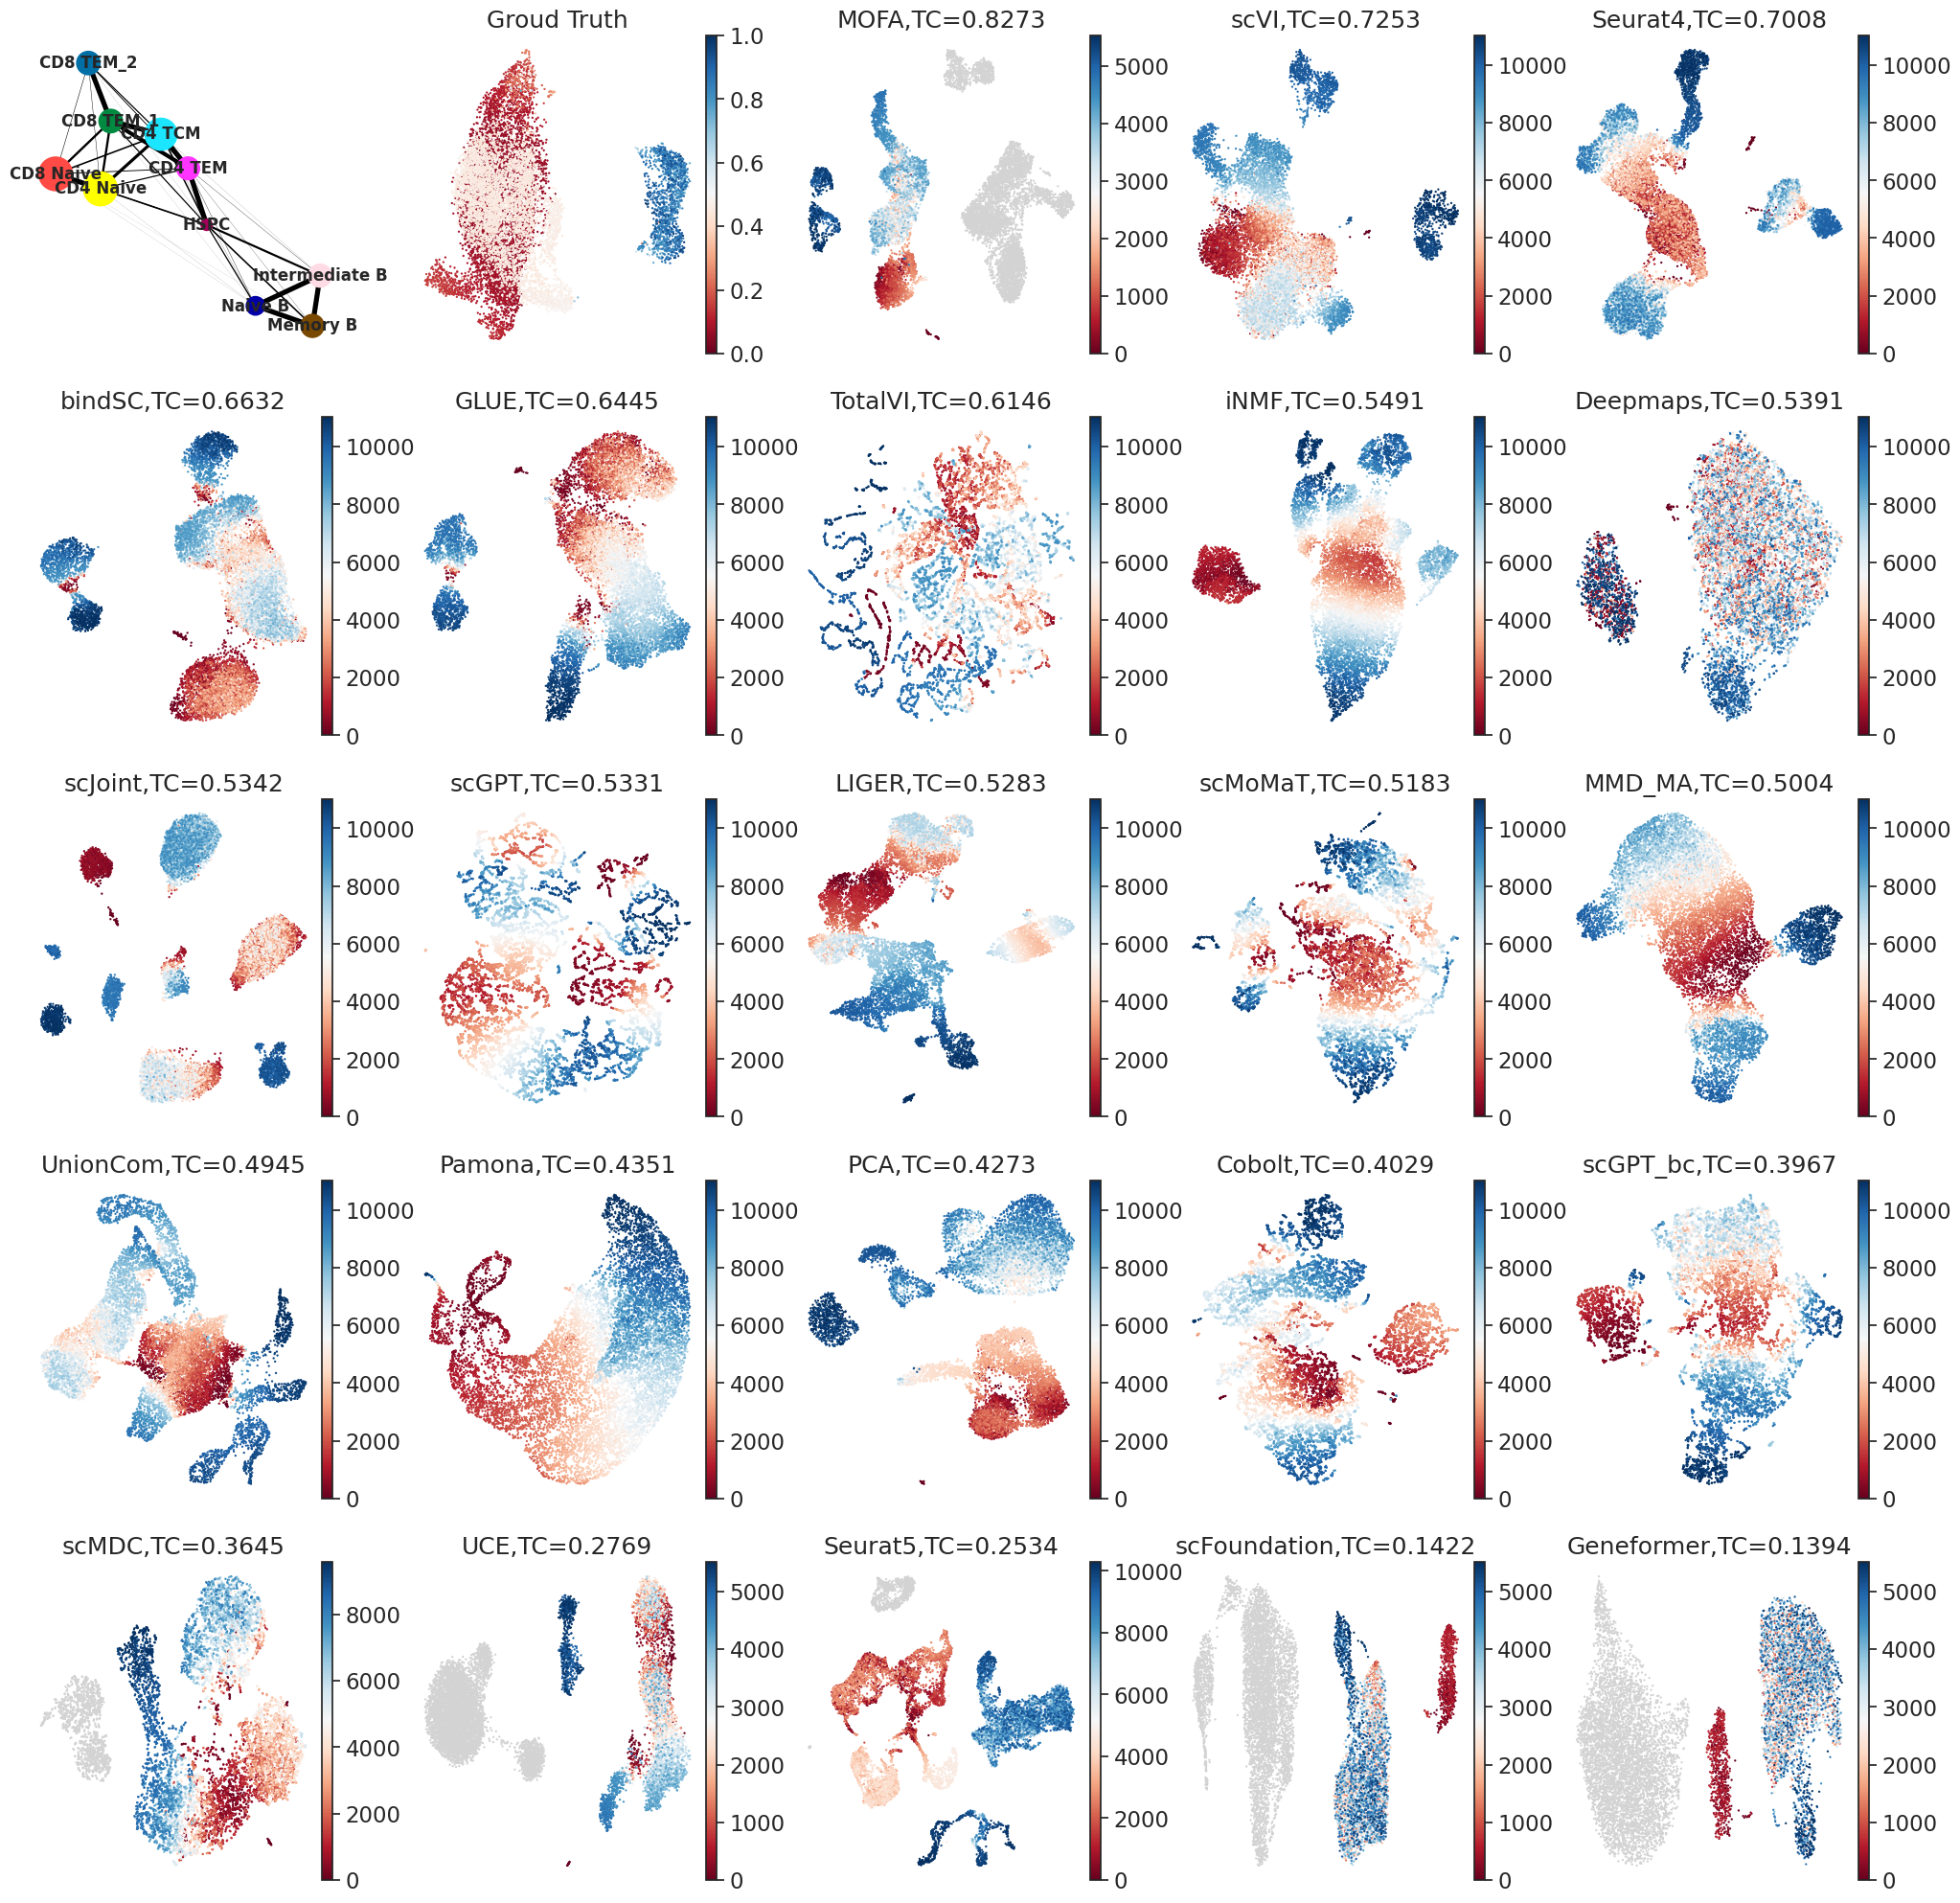

In [15]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 25))
for ax in axes.flatten():
    ax.axis('off')
sc.tl.paga(umap['Ground Truth'], groups='cell_type')
sc.pl.paga(umap['Ground Truth'],node_size_scale=2,edge_width_scale=0.5,ax=axes[0,0],show=False,fontsize=12)
j = 0
idx = 0  
for k in sorted_keys:
    if (idx+1)%5 == 0:
        j=j+1
    if idx == 0:
        sc.pl.umap(umap[k], color='dpt_pseudotime',title='Groud Truth',show=False, frameon=False, ax=axes[j,(idx+1)%5], cmap="RdBu")
        
    else:
        # break
        sc.pl.umap(umap[k], color='dpt_after',title=k+',TC='+str(round(float(scores[k]), 4)),show=False, frameon=False, ax=axes[j,(idx+1)%5], cmap="RdBu")
    idx += 1
fig.savefig('/data2/yixuan/SCMBench/tutorials/analysis/traj/10x_umap.png',dpi=400)
    

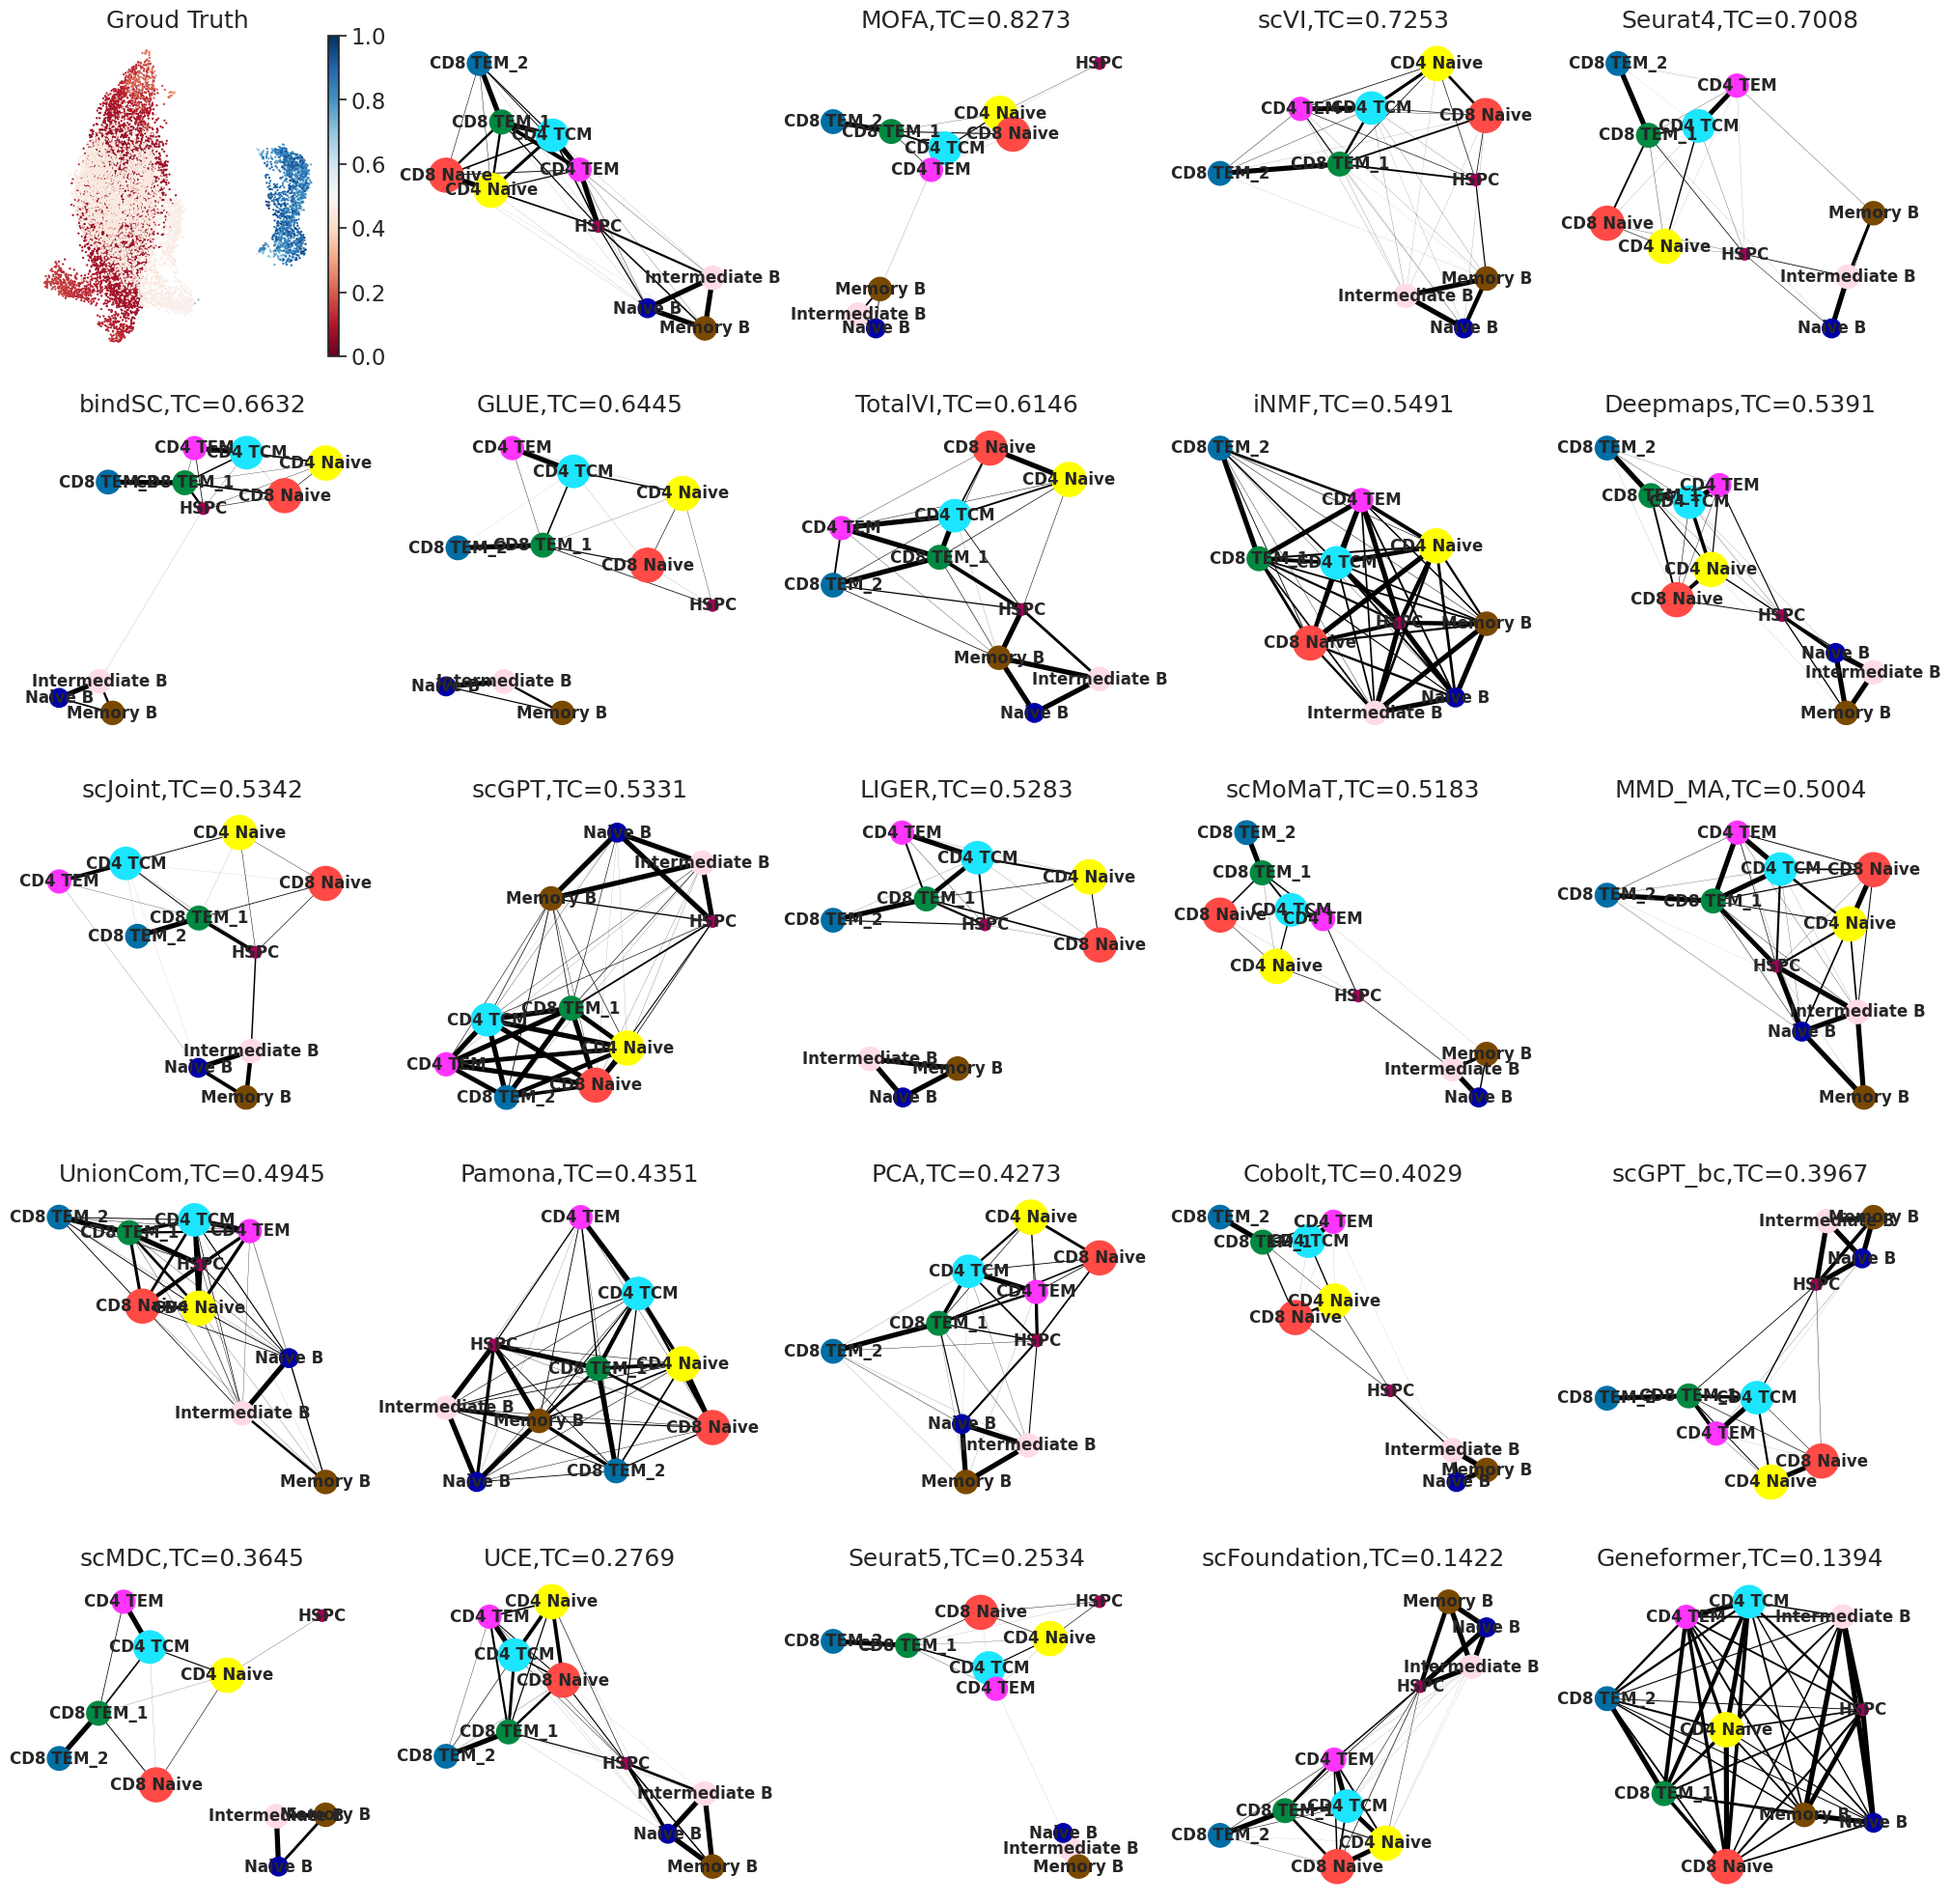

In [16]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 25))
for ax in axes.flatten():
    ax.axis('off')

sc.pl.umap(umap['Ground Truth'], color='dpt_pseudotime',title='Groud Truth',show=False, frameon=False, ax=axes[0,0], cmap="RdBu")
j = 0
idx = 0 
for k in sorted_keys:
    if (idx+1)%5 == 0:
        j=j+1
    if idx == 0:
        sc.tl.paga(umap[k], groups='cell_type')
        sc.pl.paga(umap[k],node_size_scale=2,edge_width_scale=0.5, ax=axes[j,(idx+1)%5],show=False,fontsize=12)        
    else:
        sc.tl.paga(umap[k], groups='cell_type')
        sc.pl.paga(umap[k],node_size_scale=2,edge_width_scale=0.5, ax=axes[j,(idx+1)%5],show=False,fontsize=12,title=k+',TC='+str(round(float(scores[k]), 4)))  
    
    idx += 1

fig.savefig('/data2/yixuan/SCMBench/tutorials/analysis/traj/10x_connect.png',dpi=400)

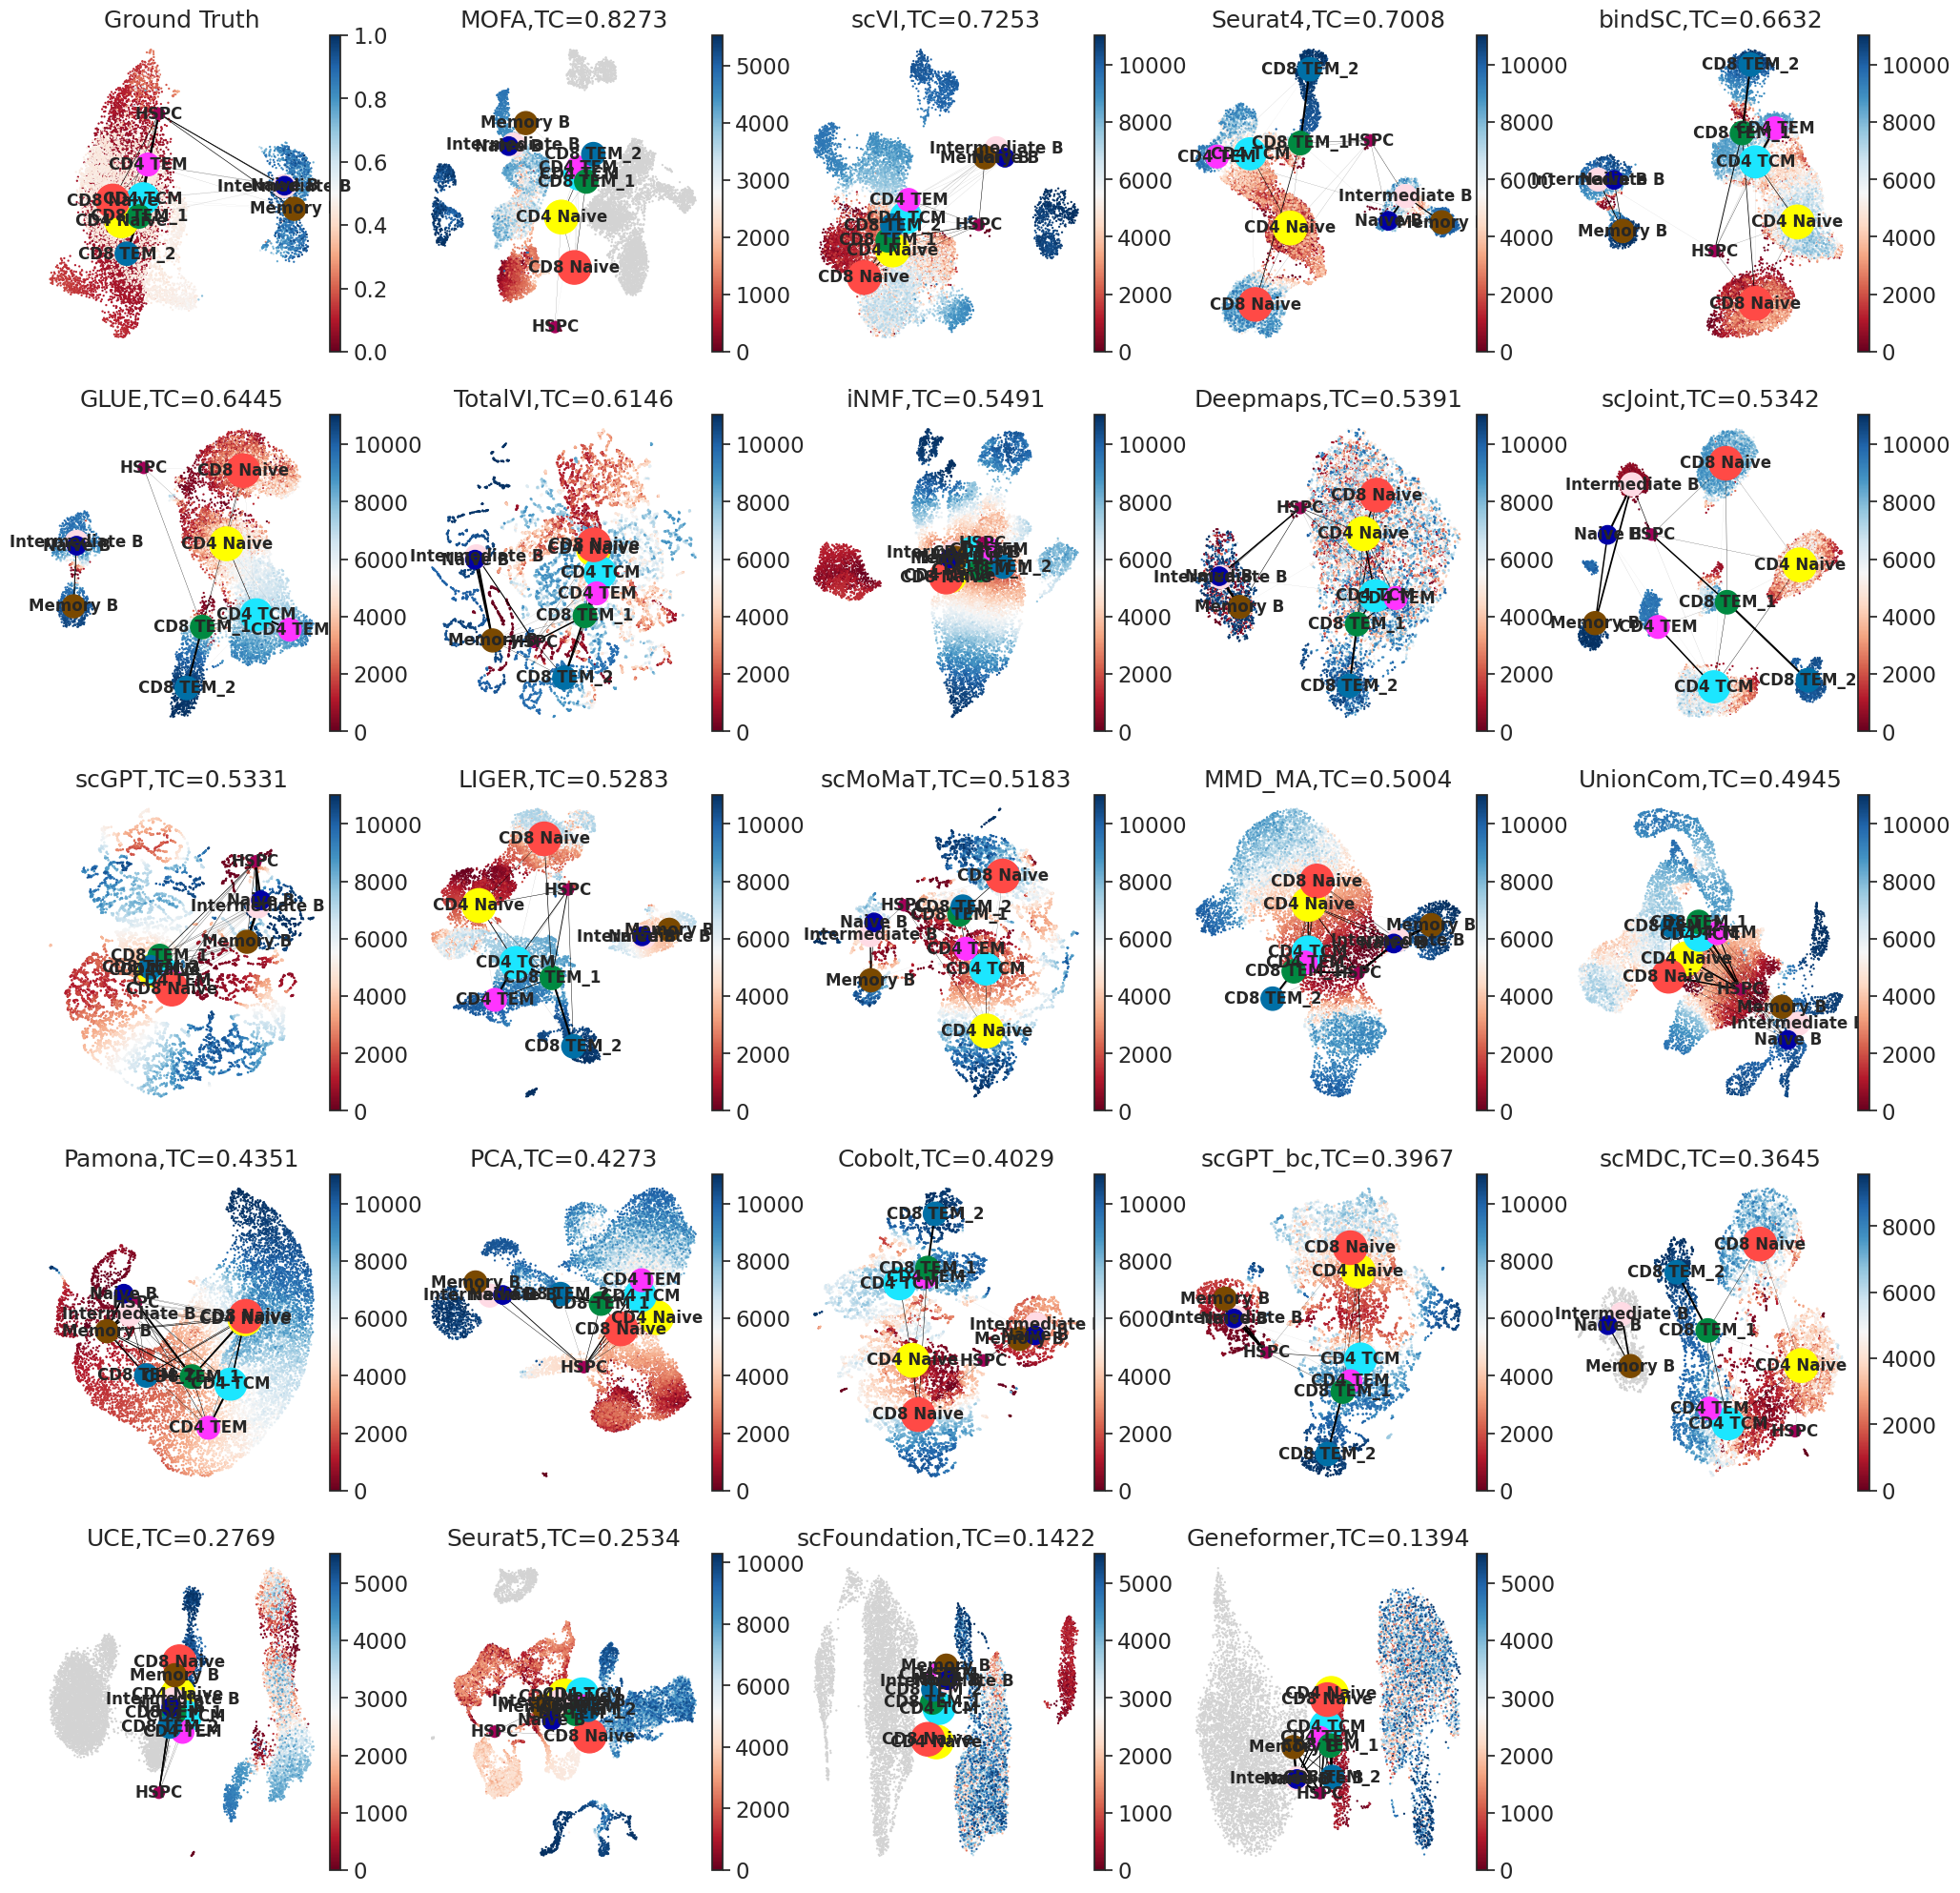

In [17]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 25))
for ax in axes.flatten():
    ax.axis('off')
j=0
idx = 0  
for k in sorted_keys:
    if idx%5==0:
        j=j+1
    if idx==0:
        pos = pd.DataFrame(umap[k].obsm["X_umap"], index=umap[k].obs_names)
        pos["group"] = umap[k].obs[umap[k].uns["paga"]["groups"]]
        pos = pos.groupby("group", observed=True).mean()

        # Plot UMAP in the background
        sc.pl.umap(umap[k], color='dpt_pseudotime',title=k,show=False, frameon=False, ax=axes[j-1,idx%5], cmap="RdBu")
        # Plot PAGA ontop of the UMAP
        sc.pl.paga(
            umap[k],
            color="cell_type",
            # threshold=0.2,
            node_size_scale=2,
            edge_width_scale=0.2,
            pos=pos.values,
            random_state=0,
            ax=axes[j-1,idx%5],
            show=False,
            fontsize=12,
            cmap='Set3',
        )
        
    else:
        # break
        # sc.pl.umap(i, color='dpt_after',title=titles[idx-1]+',TC='+str(scores[idx-1]),show=False, frameon=False, ax=axes[j,idx%5])
        pos = pd.DataFrame(umap[k].obsm["X_umap"], index=umap[k].obs_names)
        pos["group"] = umap[k].obs[umap[k].uns["paga"]["groups"]]
        pos = pos.groupby("group", observed=True).mean()

        # Plot UMAP in the background
        sc.pl.umap(umap[k], color='dpt_after',title=k+',TC='+str(round(float(scores[k]), 4)),show=False, frameon=False, ax=axes[j-1,idx%5], cmap="RdBu", legend_loc='none')
        # Plot PAGA ontop of the UMAP
        sc.pl.paga(
            umap[k],
            color="cell_type",
            # threshold=0.2,
            node_size_scale=2,
            edge_width_scale=0.2,
            pos=pos.values,
            random_state=0,
            ax=axes[j-1,idx%5],
            show=False,
            fontsize=12,
            cmap='Set3',
        )
    idx += 1

fig.savefig('/data2/yixuan/SCMBench/tutorials/analysis/traj/10x_comb.png',dpi=400)
    